Some definitions

In [1]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np
from pysaliency.datasets import Stimulus, Fixations,  StimuliStimulus
import pysaliency
from pysaliency.external_datasets.sjtuvis import TextDescriptor

def handle_stimulus(stimulus):
    """
    Make sure that a stimulus is a `Stimulus`-object
    """
    if not isinstance(stimulus, Stimulus):
        stimulus = Stimulus(stimulus)
    return stimulus

import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch    
from typing import Optional, Tuple, List, Dict, Any, Union, Sequence
import pysaliency
DEVICE = 'cuda'

class DeepGazeSaliencyModel(pysaliency.SaliencyMapModel):
    
    def __init__(self, block_num=7, dst_w=720, version = 1):
        super().__init__()
        if version == 1:
            self.model = deepgaze_pytorch.DeepGazeI(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = False
        elif version == 2:
            self.model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = False
        elif version == 3:
            self.model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = True
        self.block_num = block_num
        self.dst_w = dst_w
        
    def _saliency_map(self, stimulus, text_description:Optional[str]=None):
        image = stimulus
        # print("The input image....")
        # print(image.shape, image.dtype, np.min(image), np.max(image))
        fixation_history_x = np.array([1024//2, 300, 500, 200, 200, 700])
        fixation_history_y = np.array([768//2, 300, 100, 300, 100, 500])

        centerbias_template = np.load('../../pretrained_weights/deepgaze/centerbias_mit1003.npy')
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        centerbias -= logsumexp(centerbias)

        image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
        centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

        if self.use_hist_scan_path:
            x_hist_tensor = torch.tensor([fixation_history_x[self.model.included_fixations]]).to(DEVICE)
            y_hist_tensor = torch.tensor([fixation_history_y[self.model.included_fixations]]).to(DEVICE)
            log_density_prediction = self.model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)
        else:
            log_density_prediction = self.model(image_tensor, centerbias_tensor)

        # f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        # axs[0].imshow(image)
        # axs[0].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        # axs[0].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        # axs[0].set_axis_off()
        # axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
        # axs[1].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        # axs[1].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        # axs[1].set_axis_off()
        if log_density_prediction.dim() == 2:
            pass
        elif log_density_prediction.dim() == 4:
            log_density_prediction = log_density_prediction[0, 0]
        elif log_density_prediction.dim() == 3:
            print(log_density_prediction.shape)
            assert log_density_prediction.shape[0] == 1
            log_density_prediction = log_density_prediction[0]
        assert log_density_prediction.dim() == 2, "log_density_prediction should be a 3D tensor, but is {}".format(log_density_prediction.shape)
        return log_density_prediction.detach().cpu().numpy()
    
data_location = "../../datasets/"
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
print(text_descriptor.get_description('000000020777_2.png')) 
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis("../../datasets/test/original_sjtuvis_dataset", location=data_location, text_descriptor=text_descriptor)

class LavisTextGuidedSaliencyModel(pysaliency.SaliencyMapModel):
    
    def __init__(self, debug_vis_flag = False, cache_location=None, caching=True, memory_cache_size=None):
        super().__init__(cache_location, caching, memory_cache_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model, self.vis_processors, self.text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=self.device, is_eval=True)
        self.debug_vis_flag = debug_vis_flag
        self.deepgaze_model = DeepGazeSaliencyModel(version=3)
        
    def saliency_map(self, stimulus):
        """
        Get saliency map for given stimulus.

        To overwrite this function, overwrite `_saliency_map` as otherwise
        the caching mechanism is disabled.
        """
        if isinstance(stimulus, StimuliStimulus):
            filename = os.path.basename(stimulus.filename)
        elif isinstance(stimulus, Stimulus):
            filename = None
        elif isinstance(stimulus, np.ndarray):
            filename = None
        else:
            raise NotImplementedError
        stimulus = handle_stimulus(stimulus)
            
        try:
            text_description=text_descriptor.get_description(filename)
        except Exception as e:
            text_description=None
        # print(text_description, stimulus.filename)
        if text_description is None:
            return self.deepgaze_model.saliency_map(stimulus.stimulus_data)
        else:
            # print(text_description)
            pass
        if not self.caching:
            return self._saliency_map(stimulus.stimulus_data, text_description=text_description)
        stimulus_id = stimulus.stimulus_id
        if not stimulus_id in self._cache:
            temp = stimulus.stimulus_data
            self._cache[stimulus_id] = self._saliency_map(temp, text_description=text_description)
        return self._cache[stimulus_id]
    
    def _saliency_map(self, stimulus, text_description=None):
        
        # print(f"****************      {text_description}      *********************")
        
        return self.evaluate_saliency_map(stimulus[...,:3], "large", text_description)
    
    def evaluate_saliency_map(self, raw_image, model_path, caption, block_num=7, dst_w=720):
        # print(raw_image.shape, raw_image.dtype, np.max(raw_image), np.min(raw_image))
        raw_image = Image.fromarray(np.uint8(raw_image)).convert('RGB')
        norm_img = np.float32(raw_image) / 255

        # Preprocess image and text inputs
        img = self.vis_processors["eval"](raw_image).unsqueeze(0).to(self.device)
        txt = self.text_processors["eval"](caption)

        # Compute GradCam
        txt_tokens = self.model.tokenizer(txt, return_tensors="pt").to(self.device)
        gradcam, _ = compute_gradcam(self.model, img, txt, txt_tokens, block_num=block_num)

        # Average GradCam for the full image
        avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True, overlap=False)
        
        if self.debug_vis_flag:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(avg_gradcam)
            ax.set_yticks([])
            ax.set_xticks([])

        overall_gradcam_wrt_tokens = []
        
        num_image = len(txt_tokens.input_ids[0]) - 2 + 1
        if self.debug_vis_flag:
            fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

        gradcam_iter = iter(gradcam[0][2:-1])
        token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

        for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
            word = self.model.tokenizer.decode([token_id])
            gradcam_image = getAttMap(norm_img, gradcam, blur=True, overlap=False)
            overall_gradcam_wrt_tokens.append(gradcam_image)
            if self.debug_vis_flag:
                ax[i].imshow(gradcam_image)
                ax[i].set_yticks([])
                ax[i].set_xticks([])
                ax[i].set_xlabel(word)

        overall_gradcam_wrt_tokens = np.stack(overall_gradcam_wrt_tokens, axis =0)
        avg_gradcam_wrt_tokens = np.mean(overall_gradcam_wrt_tokens, axis=0)
        
        if self.debug_vis_flag:
            ax[num_image-1].imshow(avg_gradcam_wrt_tokens)
            ax[num_image-1].set_yticks([])
            ax[num_image-1].set_xticks([])
            ax[num_image-1].set_xlabel(caption)
            
            plt.show()
            
        print(avg_gradcam.shape, avg_gradcam.dtype, np.max(avg_gradcam), np.min(avg_gradcam))
        print(avg_gradcam_wrt_tokens.shape, avg_gradcam_wrt_tokens.dtype, np.max(avg_gradcam_wrt_tokens), np.min(avg_gradcam_wrt_tokens))
        return avg_gradcam_wrt_tokens


# model: pysaliency.SaliencyMapModel = LavisTextGuidedSaliencyModel(debug_vis_flag=True)
# smap = model.saliency_map(mit_stimuli[10])

2023-12-14 12:14:00.449494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 12:14:00.551580: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


A fireman stood at the top of the ladder


#### Preprocess image and text inputs

------------------------    Model: ours -----------------------------------


2023-12-14 12:17:21.369 | INFO     | lavis.models:load_model_and_preprocess:152 - Loading the preprocessors from the default config file...
2023-12-14 12:17:21.370 | INFO     | lavis.models:load_model_and_preprocess:153 - args:{'model': {'arch': 'blip_image_text_matching', 'load_finetuned': True, 'finetuned': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth', 'vit_type': 'large', 'vit_grad_ckpt': False, 'vit_ckpt_layer': 0, 'image_size': 384, 'med_config_path': 'configs/models/med_large_config.json', 'embed_dim': 256}, 'preprocess': {'vis_processor': {'eval': {'name': 'blip_image_eval', 'image_size': 384}}, 'text_processor': {'eval': {'name': 'blip_caption'}}}}
2023-12-14 12:17:21.371 | INFO     | lavis.models:load_preprocess:96 - Visual pretrained model: {'eval': {'name': 'blip_image_eval', 'image_size': 384}} | Text pretrained model: {'eval': {'name': 'blip_caption'}}
Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytor

(426, 640) float32 1.0 0.0
(426, 640) float32 0.66914386 0.00788858
(416, 640) float32 1.0 0.0
(416, 640) float32 0.5651475 0.006198583
(536, 640) float32 1.0 0.0
(536, 640) float32 0.6185588 0.00049086614
(427, 640) float32 1.0 0.0
(427, 640) float32 0.43672457 0.0018561304
(480, 640) float32 1.0 0.0
(480, 640) float32 0.45748693 0.0007047423
------------------------    Model: deepgazeIIE -----------------------------------


/mnt/homes/minghao/anaconda3/envs/lavis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0
/mnt/homes/minghao/anaconda3/envs/lavis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------------------------    Model: deepgazeI -----------------------------------


Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0
/mnt/homes/minghao/anaconda3/envs/lavis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 426, 640])
torch.Size([1, 416, 640])
torch.Size([1, 536, 640])
torch.Size([1, 427, 640])
torch.Size([1, 480, 640])
------------------------    Model: deepgazeIII -----------------------------------


Using cache found in /mnt/homes/minghao/.cache/torch/hub/pytorch_vision_v0.6.0


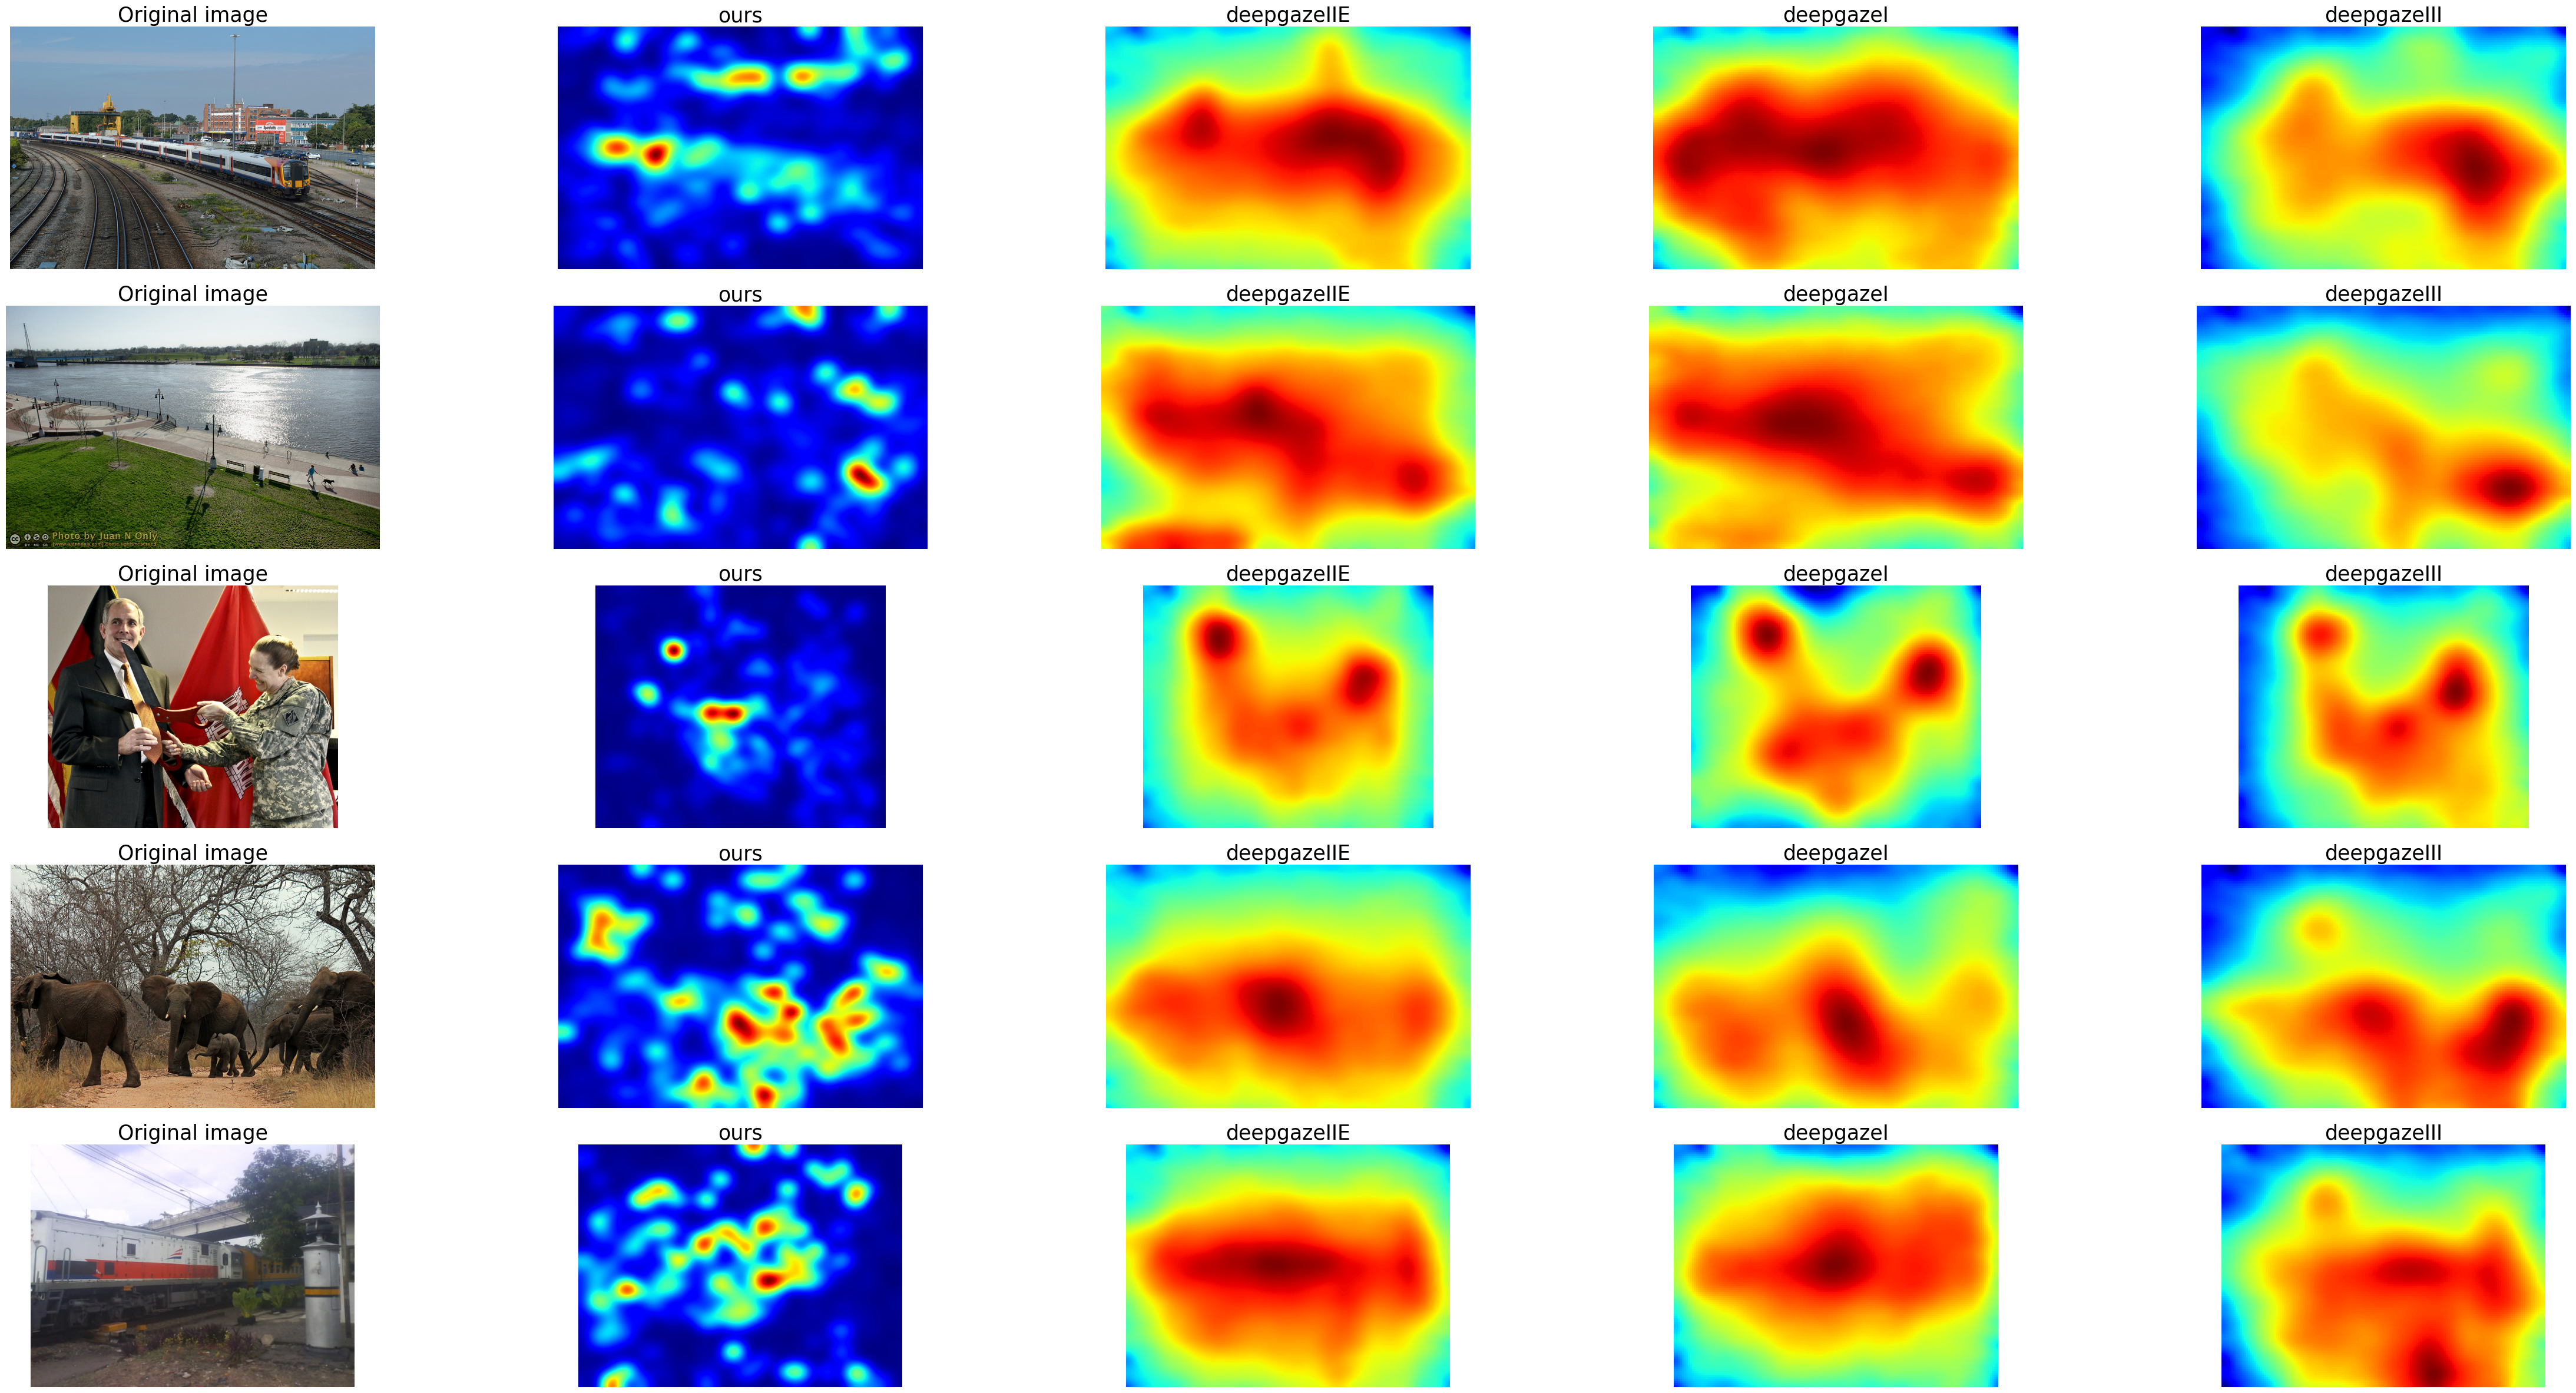

: 

In [4]:
import os
model_zoos = [  "SUN", "IttiKoch", "Judd", "CovSal","AIM", "ours", "deepgazeIIE", "deepgazeI", "deepgazeIII"]
import pysaliency
from pysaliency.external_models import AIM, SUN, GBVSIttiKoch, Judd, IttiKoch, CovSal
from pysaliency.external_datasets.sjtuvis import TextDescriptor
import numpy as np
import matplotlib.pyplot as plt
from pysaliency.saliency_map_conversion import optimize_for_information_gain

from pysaliency.external_datasets import get_mit1003, get_sjtu_vis, get_cat2000_train, get_FIGRIM, get_mit300, get_mit1003, get_mit1003_onesize, get_SALICON, get_toronto, get_DUT_OMRON, get_OSIE, get_PASCAL_S, get_NUSEF_public

DATASET_MAPPINGS = {
	"mit1003": get_mit1003,
 	"mit1003_onesize": get_mit1003_onesize,
 	"sjtuvis": get_sjtu_vis,
	# "cat2000_train": get_cat2000_train,
	"figrim": get_FIGRIM,
	"salicon_eval": get_SALICON,
	"toronto": get_toronto,
 	"DUT_OMRON": get_DUT_OMRON,
	"OSIE": get_OSIE,
	"PASCAL_S": get_PASCAL_S,
	"NUSEF_public": get_NUSEF_public
}

import pandas as pd
columns = ['Model', 'Dataset', 'AUC_shuffled', 'AUC_uniform', 'KL_uniform', 'KL_shuffled', 'KL_identical_nonfixations', 'Image_based_KL_divergence']
results_df = pd.DataFrame(columns=columns)


from pysaliency.external_datasets.sjtuvis import TextDescriptor
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
data_location = "../../datasets/test"
original_dataset_path = "../../datasets/test/original_sjtuvis_dataset"
cutoff = 10
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis(original_dataset_path=original_dataset_path, location=data_location, text_descriptor = text_descriptor)
short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
short_fixations = mit_fixations[mit_fixations.n < cutoff]


model_zoos = model_zoos[5:]
num_rows = 5
fig, ax = plt.subplots(num_rows, len(model_zoos) + 1, figsize=(60, 30))

for idx in range(num_rows):
	img_idx = 4 * idx + 1
	ax[idx, 0].imshow(mit_stimuli[img_idx].stimulus_data)
 
	title = ax[idx, 0].set_title("Original image", fontsize=25)
	title.set_y(1.05)
	title.set_multialignment('center')
	title.set_linespacing(1.5)

	ax[idx, 0].axis('off')


for model_idx, model_name in enumerate(model_zoos):
	print(f"------------------------    Model: {model_name} -----------------------------------")
	model: pysaliency.SaliencyMapModel
	model_location = "../../models/"
	if model_name == "deepgazeI":
		model: pysaliency.SaliencyMapModel = DeepGazeSaliencyModel(version=1)
	elif model_name == "deepgazeIIE":
		model: pysaliency.SaliencyMapModel = DeepGazeSaliencyModel(version=2)
	elif model_name == "deepgazeIII":
		model: pysaliency.SaliencyMapModel = DeepGazeSaliencyModel(version=3)
	elif model_name == "ours":
		model: pysaliency.SaliencyMapModel = LavisTextGuidedSaliencyModel()
	elif model_name == "GoldStandard":
		raise NotImplementedError
	else:
		model: pysaliency.SaliencyMapModel = eval(model_name)(location = model_location, cache_location=os.path.join('../../datasets/model_caches/', model_name), caching=True)

	for i in range(num_rows):
		img_idx = 4 * i + 1
		smap = model.saliency_map(mit_stimuli[img_idx])
		ax[i, model_idx + 1].imshow(smap, cmap='jet')


		title = ax[i, model_idx + 1].set_title(model_name, fontsize=25)
		title.set_y(1.05)
		title.set_multialignment('center')
		title.set_linespacing(1.5)
	
		ax[i, model_idx + 1].axis('off')
		

plt.subplots_adjust(wspace=0, hspace=0.15)  # Remove gaps between subplots
plt.show()

  